### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


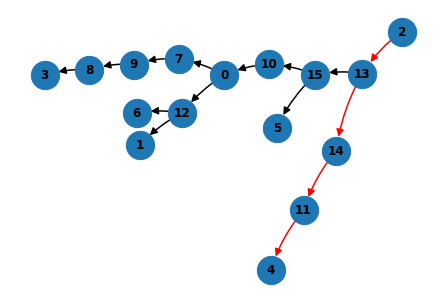

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

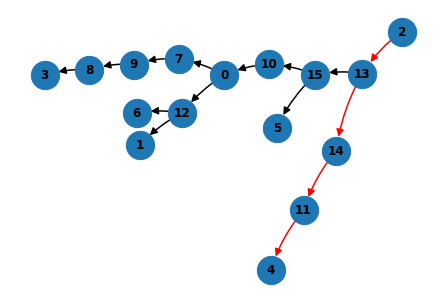

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 6>8,10>13,7>6,11>12,4>3,9>11,6>1,0>14,12>5,15>7,13>0,1>4,12>15,5>10,2>9|14:2
Completion: >9>11>12>5>10>13>0>14

Prompt: 11>4,8>15,9>8,5>11,4>6,4>10,9>1,5>2,2>13,5>9,13>14,12>3,13>0,15>7,3>5|7:12
Completion: >3>5>9>8>15>7

Prompt: 2>15,12>9,10>4,11>7,14>8,11>3,2>1,15>11,10>2,0>12,14>10,10>5,8>6,1>13,14>0|7:14
Completion: >10>2>15>11>7

Prompt: 13>8,12>7,11>5,1>12,12>11,6>3,12>14,6>4,10>1,0>9,2>13,2>15,8>10,14>6,5>0|3:2
Completion: >13>8>10>1>12>14>6>3

Prompt: 14>4,9>3,12>5,10>6,1>9,11>10,0>13,4>8,13>15,12>2,8>1,9>7,11>12,13>11,0>14|6:0
Completion: >13>11>10>6

Prompt: 10>7,4>8,13>6,1>3,0>9,3>4,15>0,2>5,3>15,14>13,2>1,11>12,13>10,3>11,13>2|9:14
Completion: >13>2>1>3>15>0>9

Prompt: 10>5,9>13,10>8,1>6,15>14,0>4,1>3,14>10,14>12,7>0,6>11,3>9,1>15,3>2,8>7|2:1
Completion: >3>2

Prompt: 8>6,12>7,4>1,12>15,14>10,8>5,4>2,6>0,13>12,2>3,3>14,11>4,0>11,13>8,14>9|1:13
Completion: >8>6>0>11>4>1

Prompt: 4>14,12>8,0>4,0>9,6>1,15>5,13>11,0>12,9>6,5>13,11>0,14>2,15>3,7>15,12>10|1:7
Completion: 

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [7]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


15>3,7>4,13>15,13>7,1>6,0>5,0>13,0>1,10>8,10>11,2>9,2>0,2>10,14>2,12>14|3:12>14>2>0>13>15>3


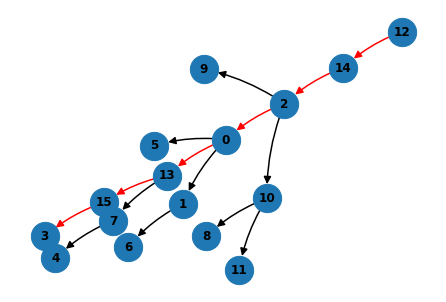

In [8]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [9]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: Looking at Embeddings

In [10]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score

X = all_nodes
y = np.zeros((32,))
y[16:] = 1.0

probe = LinearRegression().fit(X, y)
# Calculate train loss
y_pred = probe.predict(X)
loss = mean_squared_error(y, y_pred)
loss

1.3222756223285614e-13

In [12]:
y_pred[:16]

array([5.9604645e-08, 2.9802322e-07, 7.1525574e-07, 5.9604645e-08,
       1.7881393e-07, 2.9802322e-07, 1.7881393e-07, 2.6822090e-07,
       2.3841858e-07, 2.3841858e-07, 3.5762787e-07, 3.8743019e-07,
       5.3644180e-07, 3.5762787e-07, 5.6624413e-07, 1.4901161e-07],
      dtype=float32)

In [13]:
probe

LinearRegression()

In [14]:
embedding_matrix.mean(axis=1)

array([-6.9849193e-10,  0.0000000e+00, -6.9849193e-10,  1.6298145e-09,
       -2.3283064e-10, -4.6566129e-10, -4.6566129e-10, -2.7939677e-09,
        1.3969839e-09, -1.6298145e-09, -1.8626451e-09, -1.3969839e-09,
        4.6566129e-10,  9.3132257e-10,  6.9849193e-10,  9.3132257e-10,
        3.0267984e-09,  0.0000000e+00, -2.0954758e-09,  1.8626451e-09,
        0.0000000e+00,  1.3969839e-09,  2.3283064e-10,  2.5611371e-09,
       -2.3283064e-09,  2.9103830e-09, -9.3132257e-10,  1.8626451e-09,
        0.0000000e+00,  0.0000000e+00, -1.2223609e-09,  4.6566129e-10,
       -6.9849193e-10, -4.6566129e-10, -9.3132257e-10], dtype=float32)

In [15]:
incoming_embeddings

array([[-0.05955783, -0.04651975, -0.0774742 , ...,  0.04724649,
         0.01560289,  0.23823978],
       [ 0.0007991 , -0.02041807,  0.1056877 , ..., -0.11498069,
         0.05794969, -0.15996033],
       [-0.00158451, -0.15038358, -0.05534289, ..., -0.07480281,
        -0.0103944 , -0.13729659],
       ...,
       [-0.05465658, -0.08668789,  0.00939552, ...,  0.09229839,
         0.00196997,  0.17450233],
       [-0.00762075,  0.05404986,  0.05568255, ...,  0.12652203,
         0.07268702,  0.01046259],
       [-0.01615055,  0.0133104 , -0.07818068, ...,  0.09386133,
         0.11359201, -0.09077817]], dtype=float32)

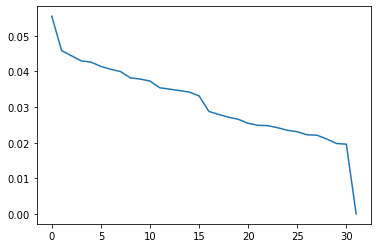

In [16]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(all_nodes)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [17]:
pca.explained_variance_

array([5.6174830e-02, 4.6398316e-02, 4.4956144e-02, 4.3476142e-02,
       4.3142240e-02, 4.1912436e-02, 4.1101836e-02, 4.0455479e-02,
       3.8655635e-02, 3.8324986e-02, 3.7755888e-02, 3.5837907e-02,
       3.5466801e-02, 3.5041120e-02, 3.4632459e-02, 3.3538975e-02,
       2.9120158e-02, 2.8272334e-02, 2.7490972e-02, 2.6884066e-02,
       2.5749750e-02, 2.5192598e-02, 2.5084808e-02, 2.4503822e-02,
       2.3758305e-02, 2.3356343e-02, 2.2492958e-02, 2.2375625e-02,
       2.1304838e-02, 2.0006489e-02, 1.9819580e-02, 1.0077001e-15],
      dtype=float32)

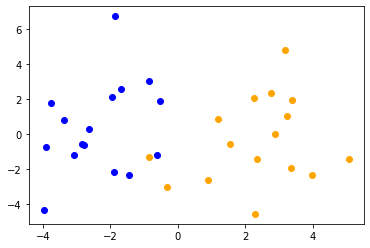

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

In [19]:
dataset.idx2tokens[3]

'>10'

In [20]:
explained_variance = pca.explained_variance_ratio_

In [21]:
import numpy as np
from numpy.linalg import norm
for i in range(15):
    for j in range(i+1, 16):
        cosine = np.dot(incoming_embeddings[i],incoming_embeddings[j])
        print(cosine)
        

0.010733113
-0.035859913
-0.04851623
-0.027139299
0.026065078
-0.036517184
-0.02968574
0.0015938133
0.011567462
-0.006220471
0.021423599
-0.017528618
-0.014885161
-0.09355475
-0.07574723
0.007934473
-0.015638433
-0.04661727
-0.02358416
-0.00072617084
-0.033552825
-0.022245392
-0.04145173
-0.028152548
-0.058678687
-0.0016360581
-0.026160255
-0.015044879
-0.012557622
-0.020163482
-0.017806718
0.02747672
-0.018918967
0.00021377206
-0.005784098
-0.026490144
-0.023694582
-0.00047623366
-0.0019229697
-0.025444325
-0.008454906
-0.005837295
-0.006465273
-0.012742924
-0.013498247
-0.009131262
-0.07055436
-0.032597028
-0.06587714
-0.0790844
-0.01600769
-0.005649736
0.007432591
-0.03795532
-0.06496724
-0.076603964
-0.0019733086
-1.5817583e-05
-0.03580276
-0.039138727
-0.0117629655
-0.04154795
-0.0069329366
0.0036419556
-0.031579457
0.0027507283
-0.02332095
-0.039326727
-0.07588942
-0.051581804
-0.046554692
-0.005816293
0.0005082339
0.04184866
-0.01244567
-0.10989564
-0.048236832
-0.05701414
-0.02

### Experiment: Probing


In [22]:
X = []
y = {"incoming": [], "outgoing": []}
graphs = []

for i in range(1_000):
    # Sample example
    test_graph = generate_example(n_states, i, order="random")
    pred, correct = eval_model(model, dataset, test_graph)
    if not correct:
        continue
    labels, cache = get_example_cache(pred, model, dataset)
    # Record information
    graphs.append(pred)
    X.append(cache["blocks.5.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])


In [23]:
from sklearn import preprocessing

X = torch.cat(X, dim=0).detach().cpu().numpy()
y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


pca = PCA(n_components=128)  # k is the desired number of components
X_pca = pca.fit_transform(X)

# instantiate the model (using the default parameters)
out_logreg = LogisticRegression(multi_class='ovr', solver='liblinear')

# fit the model with data
out_logreg.fit(X_pca, y["outgoing"])

# predict the response for new observations
y_pred = out_logreg.predict(X_pca)
score = f1_score(y["outgoing"], y_pred, average='macro')  

print("Outgoing F1 Score: ", score)


# instantiate the model (using the default parameters)
in_logreg = LogisticRegression(multi_class='ovr', solver='liblinear')

# fit the model with data
in_logreg.fit(X_pca, y["incoming"])

# predict the response for new observations
y_pred = in_logreg.predict(X_pca)
score = f1_score(y["incoming"], y_pred, average='macro')  

print("Incoming F1 Score: ", score)

Outgoing F1 Score:  1.0
Incoming F1 Score:  1.0


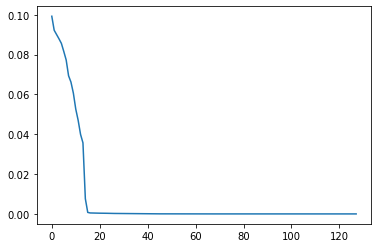

In [25]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [26]:
explained_variance[34:]

array([9.64606661e-05, 9.24542910e-05, 7.37705850e-05, 6.71598827e-05,
       6.61099184e-05, 6.24217864e-05, 5.71503515e-05, 5.29320059e-05,
       5.23242306e-05, 4.38345742e-05, 4.13075068e-05, 3.80415222e-05,
       3.41202176e-05, 3.22552078e-05, 2.95638820e-05, 2.70774781e-05,
       2.62968570e-05, 2.37549029e-05, 2.33145838e-05, 2.13258136e-05,
       1.88650683e-05, 1.67702146e-05, 1.56544920e-05, 1.40974935e-05,
       1.31494789e-05, 1.15825451e-05, 1.10796473e-05, 9.15738110e-06,
       8.48845775e-06, 7.70716542e-06, 7.16405430e-06, 6.21433719e-06,
       5.89259798e-06, 5.60536364e-06, 5.08300445e-06, 4.61381251e-06,
       4.41738666e-06, 3.84856321e-06, 3.42902922e-06, 3.28202714e-06,
       3.19435003e-06, 2.92057985e-06, 2.81176722e-06, 2.37765948e-06,
       1.99694841e-06, 1.98252997e-06, 1.76930189e-06, 1.60237641e-06,
       1.52542293e-06, 1.34018990e-06, 1.20924574e-06, 1.16354693e-06,
       1.01545538e-06, 9.71913437e-07, 9.22904348e-07, 8.52806295e-07,
      

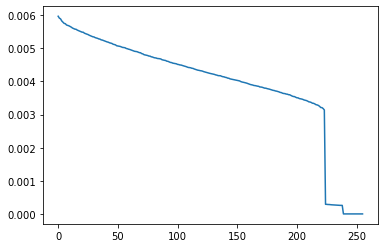

In [27]:
def extract_adj_matrix(example_str):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    return adjacency_matrix_sparse.toarray()

adj_matrices = []
for i in range(10_000):
    ex = generate_example(16, i)
    adj_matrices.append(extract_adj_matrix(ex).flatten())

adj_matrices = np.array(adj_matrices)


pca = PCA()
pca.fit(adj_matrices)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [28]:
pca = PCA(n_components=k)  # k is the desired rank of the approximation

# Fit the PCA model to the data and transform the data
X_low_rank = pca.fit_transform(X)

# To get the low-rank approximation of the original data
X_approx = pca.inverse_transform(X_low_rank)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'k' is not defined

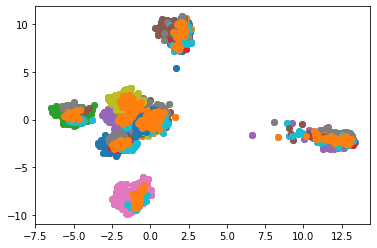

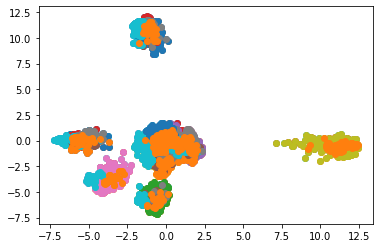

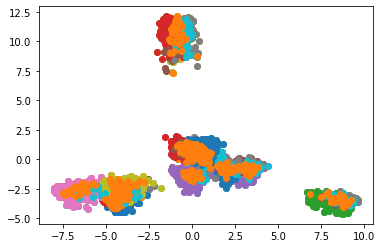

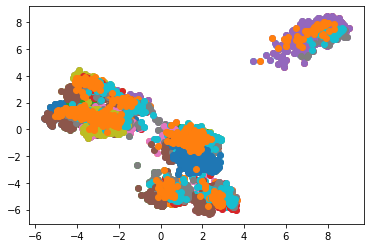

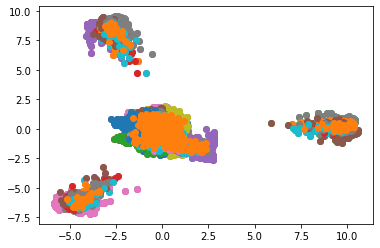

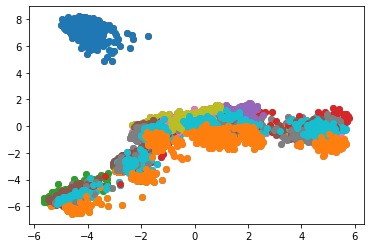

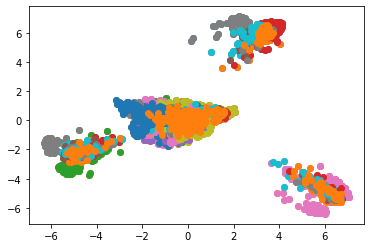

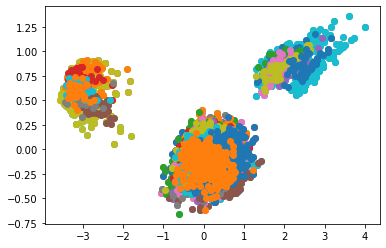

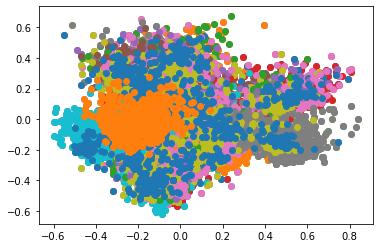

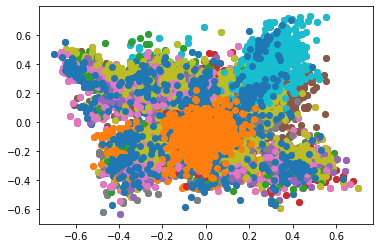

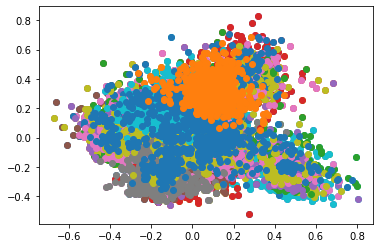

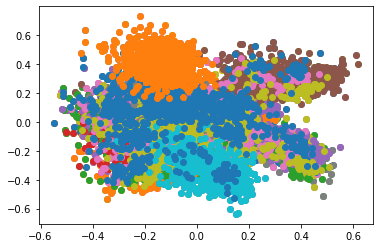

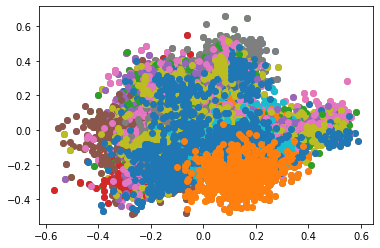

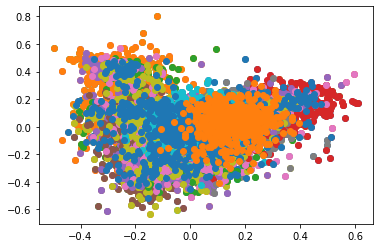

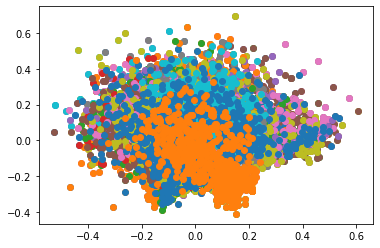

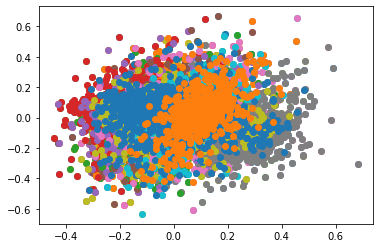

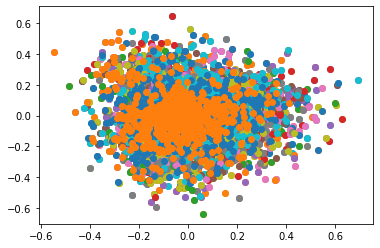

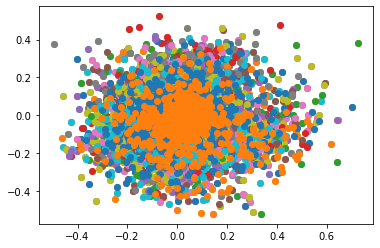

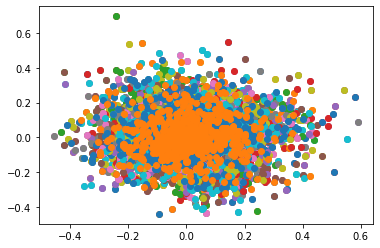

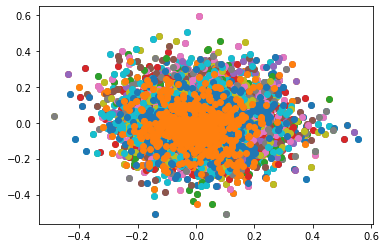

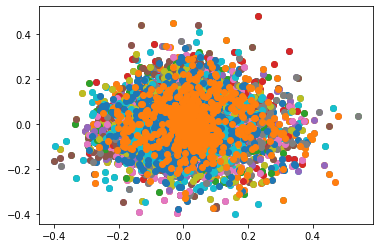

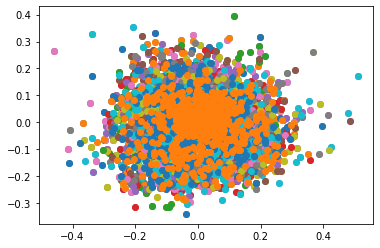

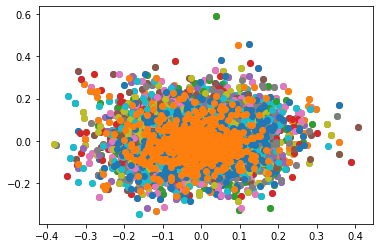

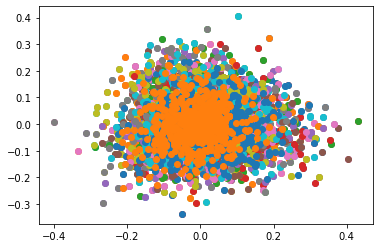

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


data_transformed = StandardScaler().fit_transform(X)
pca = PCA(n_components=48)  # k is the desired number of components
data_transformed = pca.fit_transform(data_transformed)

fig, ax = plt.subplots()


for j in range(48//2):

    for i in range(16):
        incoming_mask = y["incoming"] == i
        outgoing_mask = y["outgoing"] == i

        plt.scatter(data_transformed[incoming_mask,  2*j], data_transformed[incoming_mask, 2*j+1])
        plt.scatter(data_transformed[outgoing_mask, 2*j], data_transformed[outgoing_mask, 2*j+1])

    plt.show()


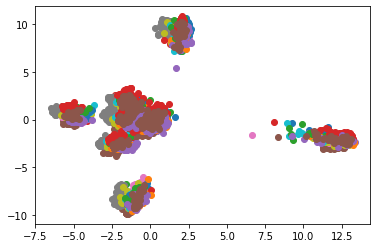

0


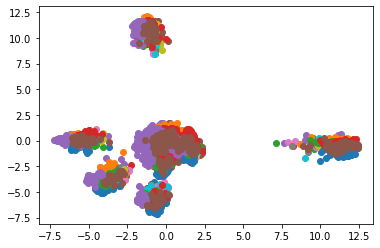

1


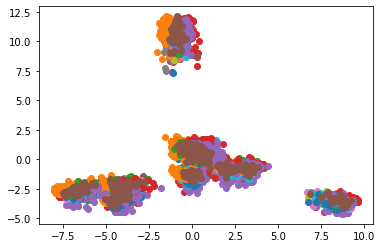

2


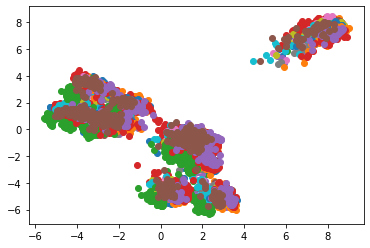

3


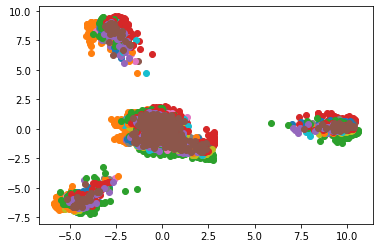

4


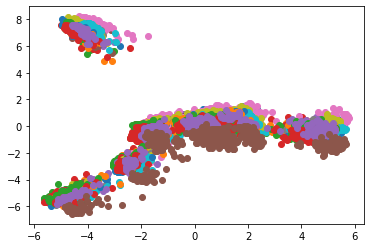

5


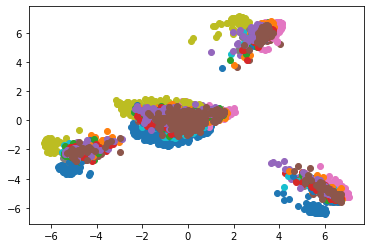

6


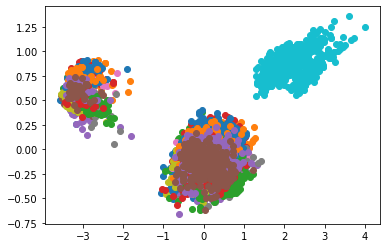

7


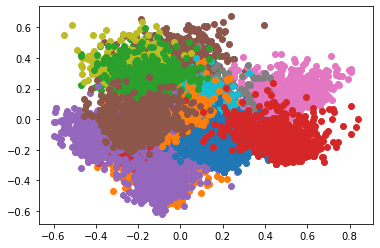

8


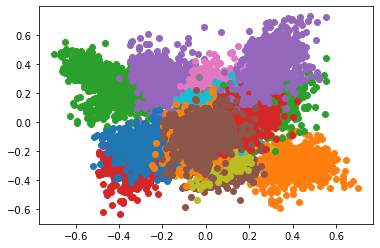

9


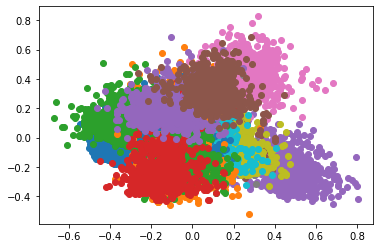

10


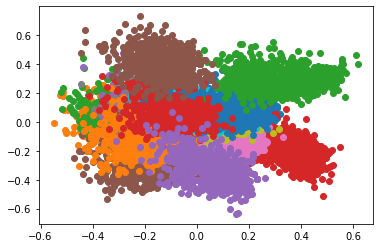

11


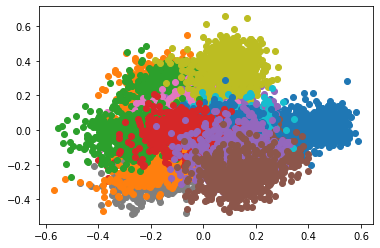

12


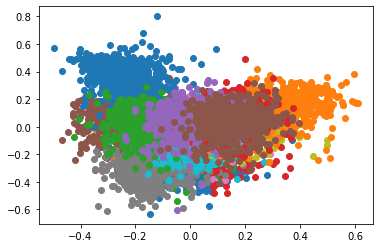

13


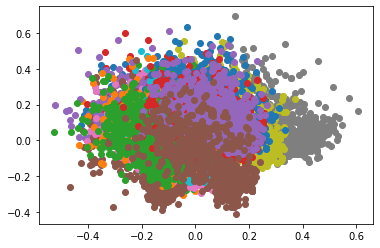

14


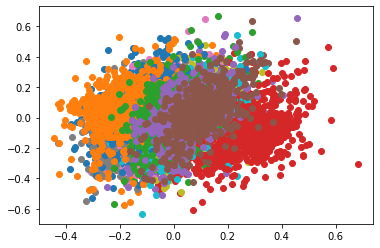

15


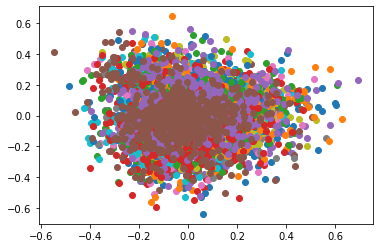

16


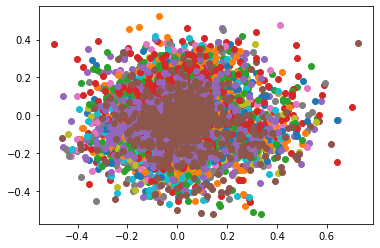

17


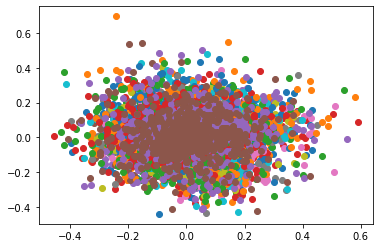

18


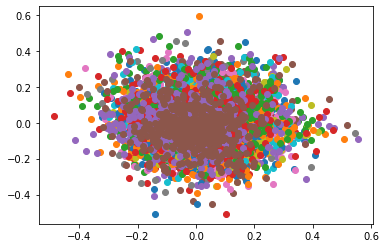

19


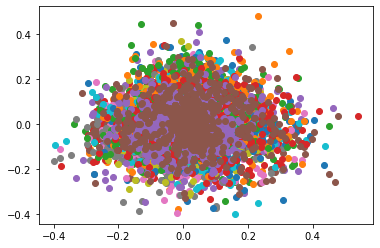

20


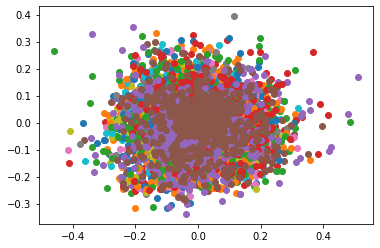

21


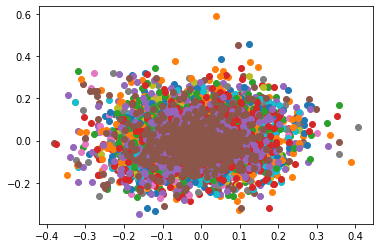

22


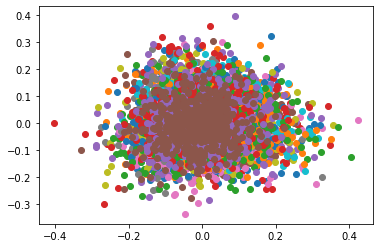

23


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


data_transformed = StandardScaler().fit_transform(X)
pca = PCA(n_components=48)  # k is the desired number of components
data_transformed = pca.fit_transform(data_transformed)

fig, ax = plt.subplots()

for j in range(48//2):
    for i in range(16):
        mask = y["outgoing"] == i
        plt.scatter(data_transformed[mask, 2*j], data_transformed[mask, 2*j+1])
    plt.show()
    print(j)

In [31]:
explained_variance[:16]

array([0.00597087, 0.00591407, 0.0058914 , 0.00582901, 0.00579187,
       0.00575518, 0.00574548, 0.00570639, 0.00569525, 0.0056817 ,
       0.00566167, 0.00564128, 0.00561441, 0.00559673, 0.00558147,
       0.00557668])

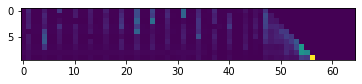

In [32]:
plt.imshow( cache["blocks.5.attn.hook_pattern"][0, 0, 47:57, :].detach().cpu() )

In [33]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_in', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out

In [34]:
import numpy as np
from numpy.linalg import norm

X_scaled = X - X.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(X_scaled, axis=1, keepdims=True)
X_scaled = X_scaled / row_norms

for i in range(14):
    for j in range(i+1, 15):
        cosine = np.dot(X_scaled[i], X_scaled[j])
        print(i, j, cosine)


0 1 -0.08909397
0 2 0.0946766
0 3 -0.13061042
0 4 -0.047457956
0 5 -0.16905487
0 6 -0.03800059
0 7 -0.14297687
0 8 -0.071640804
0 9 -0.13935906
0 10 -0.054623198
0 11 -0.06023658
0 12 -0.12141452
0 13 -0.12561156
0 14 -0.09196167
1 2 0.044752866
1 3 -0.096044004
1 4 -0.07796027
1 5 -0.07922416
1 6 -0.025482953
1 7 -0.08956019
1 8 -0.084394425
1 9 -0.1070388
1 10 -0.066508055
1 11 -0.046748083
1 12 -1.925975e-05
1 13 -0.101978905
1 14 -0.03520001
2 3 0.005472347
2 4 0.013251498
2 5 -0.19267815
2 6 0.17295353
2 7 -0.2702949
2 8 -0.13845052
2 9 0.2609815
2 10 -0.26567525
2 11 -0.08258397
2 12 0.4359102
2 13 -0.09749998
2 14 -0.018878922
3 4 -0.086547144
3 5 -0.021712203
3 6 -0.037057705
3 7 -0.11591273
3 8 -0.074947655
3 9 -0.04880939
3 10 -0.058770552
3 11 -0.015955137
3 12 -0.14607525
3 13 -0.03587927
3 14 0.0011440217
4 5 -0.06346551
4 6 -0.054628715
4 7 -0.059289224
4 8 -0.05572522
4 9 -0.053336963
4 10 -0.018971074
4 11 -0.036568508
4 12 -0.05480908
4 13 -0.078085184
4 14 0.005382288

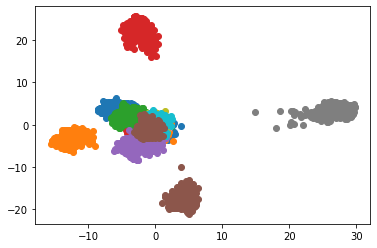

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=3)  # k is the desired number of components
data_transformed = pca.fit_transform(X)

fig, ax = plt.subplots()

for i in range(16):
    mask = y["incoming"] == i
    plt.scatter(data_transformed[mask, 0], data_transformed[mask, 1])

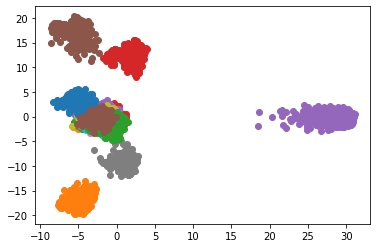

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=4)  # k is the desired number of components
data_transformed = pca.fit_transform(X)

fig, ax = plt.subplots()

for i in range(16):
    mask = y["incoming"] == i
    plt.scatter(data_transformed[mask, 2], data_transformed[mask, 3])

c:\Users\abhay\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



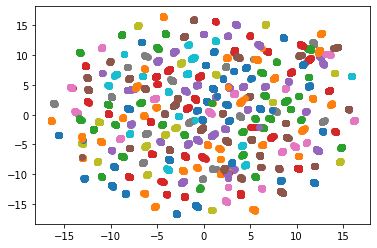

In [37]:
import umap

reducer = umap.UMAP(n_components=2)  # k is the desired number of components
data_transformed = reducer.fit_transform(X)

fig, ax = plt.subplots()

for i in range(16):
    mask = y["outgoing"] == i
    plt.scatter(data_transformed[mask, 0], data_transformed[mask, 1])

In [38]:
y["outgoing"] == 0

array([False, False, False, ..., False, False,  True])

### Experiment: Low Rank Approximation of Attention

In [39]:
def add_low_rank_hook(layer, k):
    
    X = []

    for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{layer}.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])

    X = torch.cat(X, dim=0).detach().cpu().numpy()

    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X)

    # Add low-rank hook

    from functools import partial

    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre


    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [50]:
model.reset_hooks()
add_low_rank_hook(1, 16)
add_low_rank_hook(2, 16)
add_low_rank_hook(3, 16)
add_low_rank_hook(4, 16)
add_low_rank_hook(5, 16)

In [51]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.0000%
random: 100.0000%


### Experiment: Attention Visualization + Masking

In [42]:
# Fit the PCA model to the data and transform the data
X_low_rank = pca.fit(X)

# To get the low-rank approximation of the original data
X_approx = pca.inverse_transform(X_low_rank)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\sklearn\decomposition\_base.py:158 in                 │
│ inverse_transform                                                                                │
│                                                                                                  │
│   155 │   │   │   return np.dot(X, np.sqrt(self.explained_variance_[:, np.newaxis]) *            │
│   156 │   │   │   │   │   │   │   self.components_) + self.mean_                                 │
│   157 │   │   else:                                                                              │
│ ❱ 158 │   │   │   return np.dot(X, self.components_) + self.mean_                                │
│   159                                                                                            │
│ in dot                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unsupported operand type(s) for *: 'PCA' and 'float'

### Experiment: Activation Patching

In [43]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

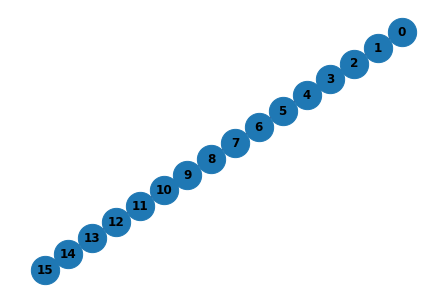

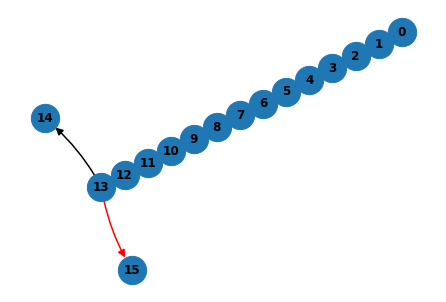

Clean logit difference: 28.632
Corrupted logit difference: -26.726
Positive Direction: >14
Negative Direction: >15


  0%|          | 0/6 [00:00<?, ?it/s]

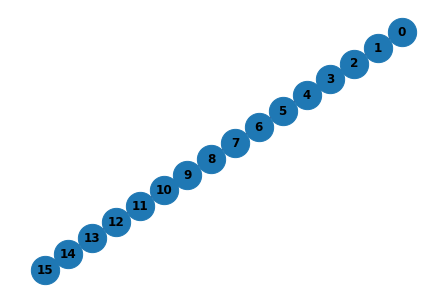

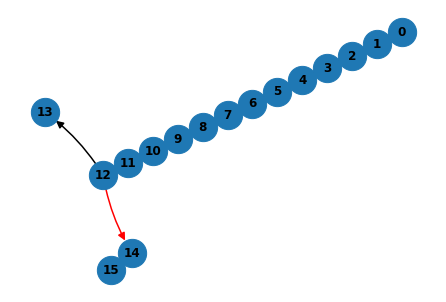

Clean logit difference: 20.599
Corrupted logit difference: -31.021
Positive Direction: >13
Negative Direction: >14


  0%|          | 0/6 [00:00<?, ?it/s]

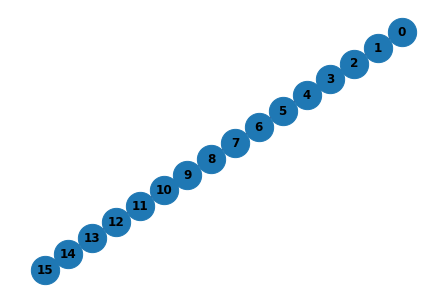

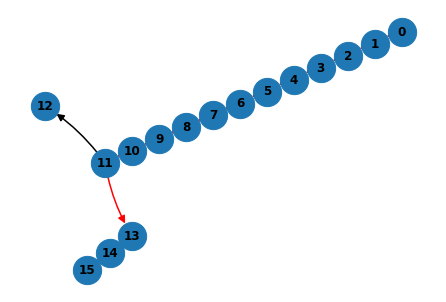

Clean logit difference: 30.959
Corrupted logit difference: -28.329
Positive Direction: >12
Negative Direction: >13


  0%|          | 0/6 [00:00<?, ?it/s]

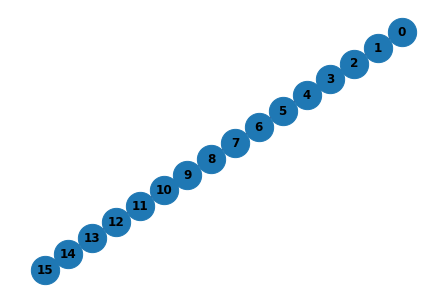

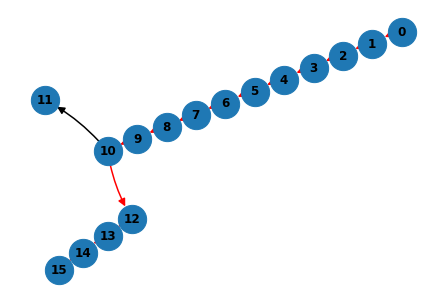

Clean logit difference: 28.172
Corrupted logit difference: -30.761
Positive Direction: >11
Negative Direction: >12


  0%|          | 0/6 [00:00<?, ?it/s]

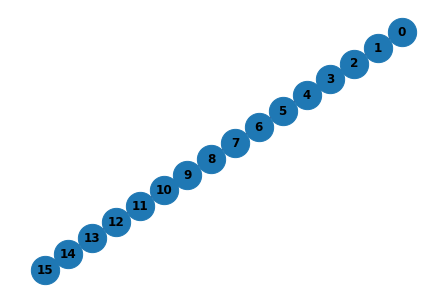

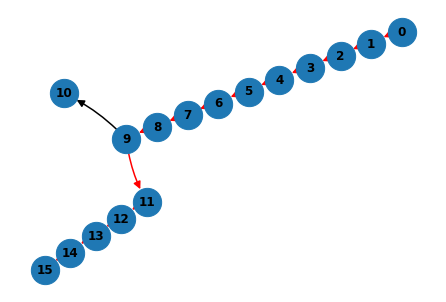

Clean logit difference: 27.548
Corrupted logit difference: -28.529
Positive Direction: >10
Negative Direction: >11


  0%|          | 0/6 [00:00<?, ?it/s]

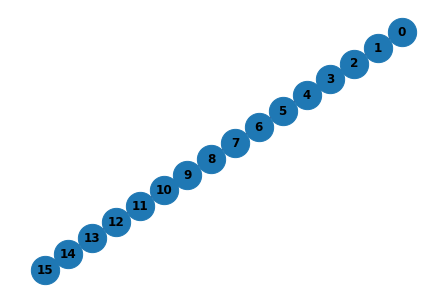

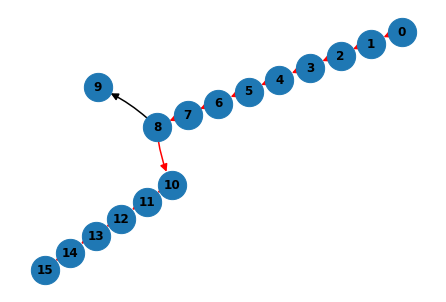

Clean logit difference: 24.128
Corrupted logit difference: -28.838
Positive Direction: >9
Negative Direction: >10


  0%|          | 0/6 [00:00<?, ?it/s]

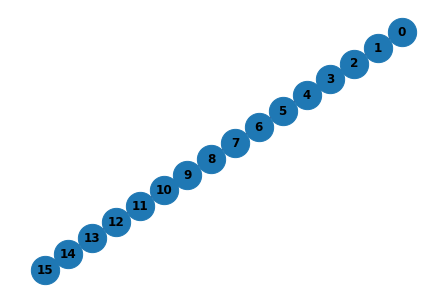

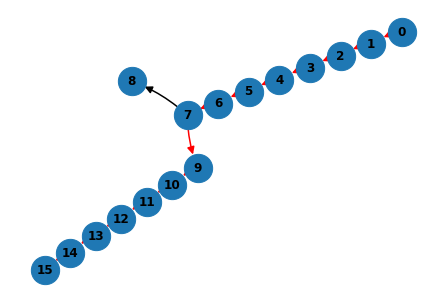

Clean logit difference: 27.738
Corrupted logit difference: -27.034
Positive Direction: >8
Negative Direction: >9


  0%|          | 0/6 [00:00<?, ?it/s]

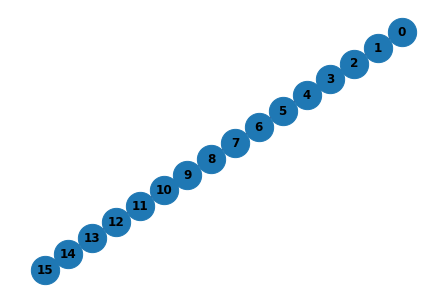

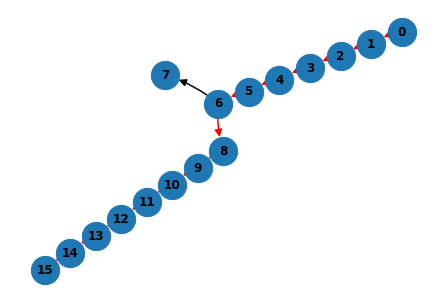

Clean logit difference: 28.092
Corrupted logit difference: -27.944
Positive Direction: >7
Negative Direction: >8


  0%|          | 0/6 [00:00<?, ?it/s]

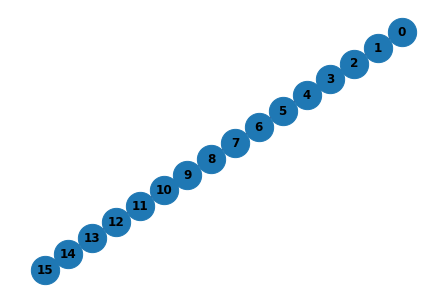

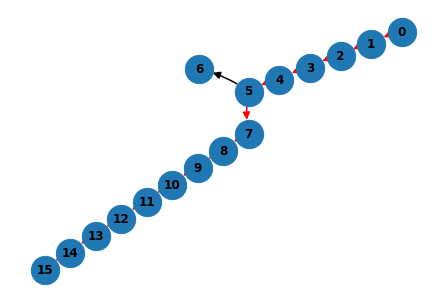

Clean logit difference: 26.328
Corrupted logit difference: -22.959
Positive Direction: >6
Negative Direction: >7


  0%|          | 0/6 [00:00<?, ?it/s]

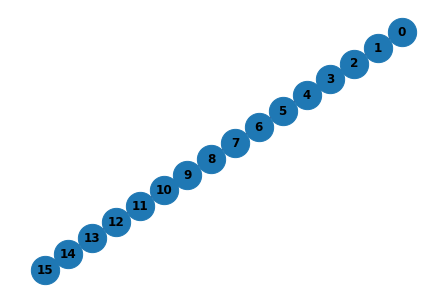

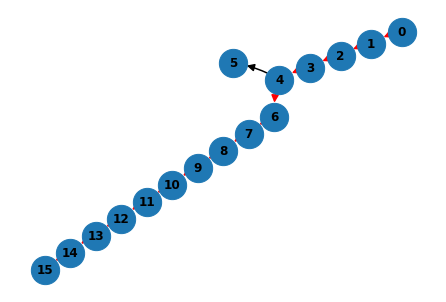

Clean logit difference: 23.962
Corrupted logit difference: -26.489
Positive Direction: >5
Negative Direction: >6


  0%|          | 0/6 [00:00<?, ?it/s]

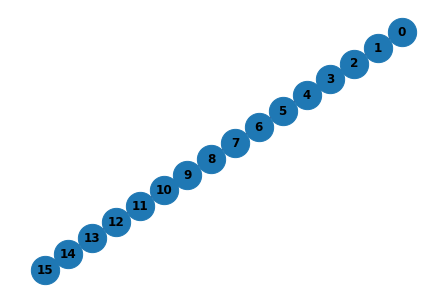

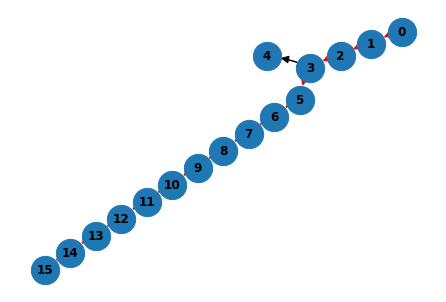

Clean logit difference: 28.749
Corrupted logit difference: -28.624
Positive Direction: >4
Negative Direction: >5


  0%|          | 0/6 [00:00<?, ?it/s]

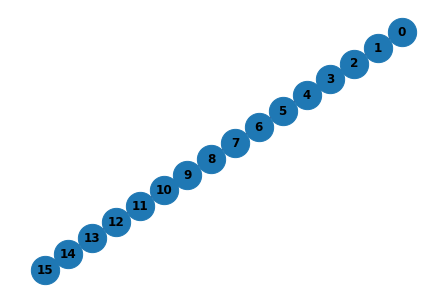

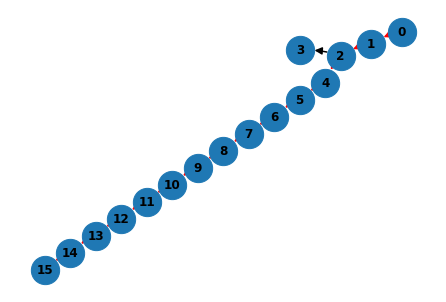

Clean logit difference: 23.565
Corrupted logit difference: -22.898
Positive Direction: >3
Negative Direction: >4


  0%|          | 0/6 [00:00<?, ?it/s]

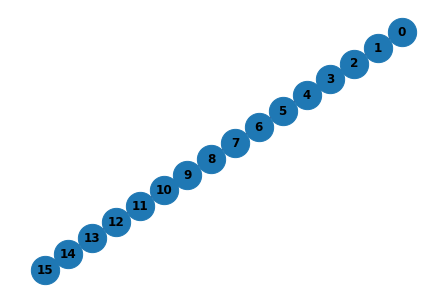

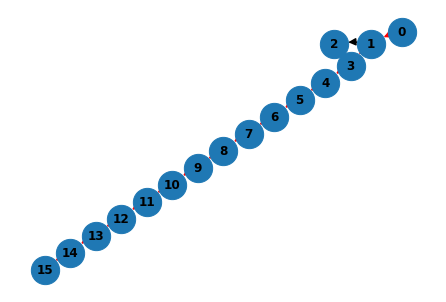

Clean logit difference: 21.542
Corrupted logit difference: -23.868
Positive Direction: >2
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

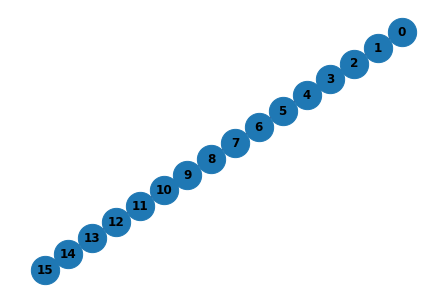

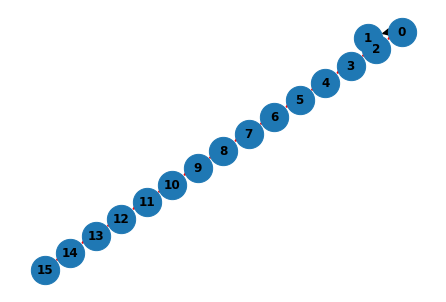

Clean logit difference: 19.914
Corrupted logit difference: -28.110
Positive Direction: >1
Negative Direction: >2


  0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

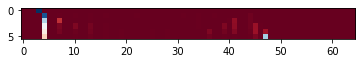

In [45]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ c:\Users\abhay\Documents\transformers_research\planning-in-transformers\interp_utils.py:106 in   │
│ plot_activations                                                                                 │
│                                                                                                  │
│   103 def plot_activations(patching_result, clean_tokens, dataset):                              │
│   104 │   # Add the index to the end of the label, because plotly doesn't like duplicate label   │
│   105 │   token_labels = [f"{dataset.idx2tokens[token]}_{index}" for index, token in enumerate   │
│ ❱ 106 │   plt.imshow(patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="   │
│   107                                                                                            │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\pyplot.py:2724 in imshow                   │
│                                                                                                  │
│   2721 │   │   alpha=None, vmin=None, vmax=None, origin=None, extent=None, *,                    │
│   2722 │   │   filternorm=True, filterrad=4.0, resample=None, url=None,                          │
│   2723 │   │   data=None, **kwargs):                                                             │
│ ❱ 2724 │   __ret = gca().imshow(                                                                 │
│   2725 │   │   X, cmap=cmap, norm=norm, aspect=aspect,                                           │
│   2726 │   │   interpolation=interpolation, alpha=alpha, vmin=vmin,                              │
│   2727 │   │   vmax=vmax, origin=origin, extent=extent,                                          │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\__init__.py:1447 in inner                  │
│                                                                                                  │
│   1444 │   @functools.wraps(func)                                                                │
│   1445 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1446 │   │   if data is None:                                                                  │
│ ❱ 1447 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1448 │   │                                                                                     │
│   1449 │   │   bound = new_sig.bind(ax, *args, **kwargs)                                         │
│   1450 │   │   auto_label = (bound.arguments.get(label_namer)                                    │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:5519 in imshow               │
│                                                                                                  │
│   5516 │   │   if aspect is None:                                                                │
│   5517 │   │   │   aspect = rcParams['image.aspect']                                             │
│   5518 │   │   self.set_aspect(aspect)                                                           │
│ ❱ 5519 │   │   im = mimage.AxesImage(self, cmap, norm, interpolation, origin, extent,            │
│   5520 │   │   │   │   │   │   │     filternorm=filternorm, filterrad=filterrad,                 │
│   5521 │   │   │   │   │   │   │     resample=resample, **k

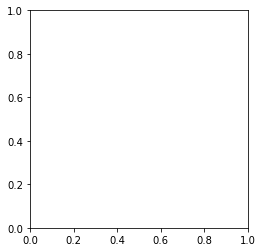

In [46]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [47]:
patchings[index][0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0